In [1]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.metrics import Recall, Precision
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D, BatchNormalization
from keras.applications import DenseNet121  
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.optimizers import SGD, Adam, RMSprop, Adagrad
from keras import layers
import multiprocessing

2023-05-05 14:37:29.546749: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-05 14:37:29.642531: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-05 14:37:29.644783: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-05 14:37:30.712464: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Define the path to the data directory
data_dir = "/media/DATA/pin/"

# Define the paths to the train and test directories
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# Define the input image size and number of classes
img_width = 224
img_height = 224
batch_size = 8

In [3]:
def visualize_data(train_dir, val_dir, test_dir):
    train_counts = []
    val_counts = []
    test_counts = []
    labels = []

    for folder in os.listdir(train_dir):
        labels.append(folder)
        train_counts.append(len(os.listdir(os.path.join(train_dir, folder))))

    for folder in os.listdir(val_dir):
        val_counts.append(len(os.listdir(os.path.join(val_dir, folder))))

    for folder in os.listdir(test_dir):
        test_counts.append(len(os.listdir(os.path.join(test_dir, folder))))

    x = np.arange(len(labels))
    width = 0.25

    fig, ax = plt.subplots(figsize=(12, 8))
    rects1 = ax.bar(x - width, train_counts, width, label='Train')
    rects2 = ax.bar(x, val_counts, width, label='Validation')
    rects3 = ax.bar(x + width, test_counts, width, label='Test')

    ax.set_ylabel('Number of Images')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    fig.tight_layout()
    plt.show()


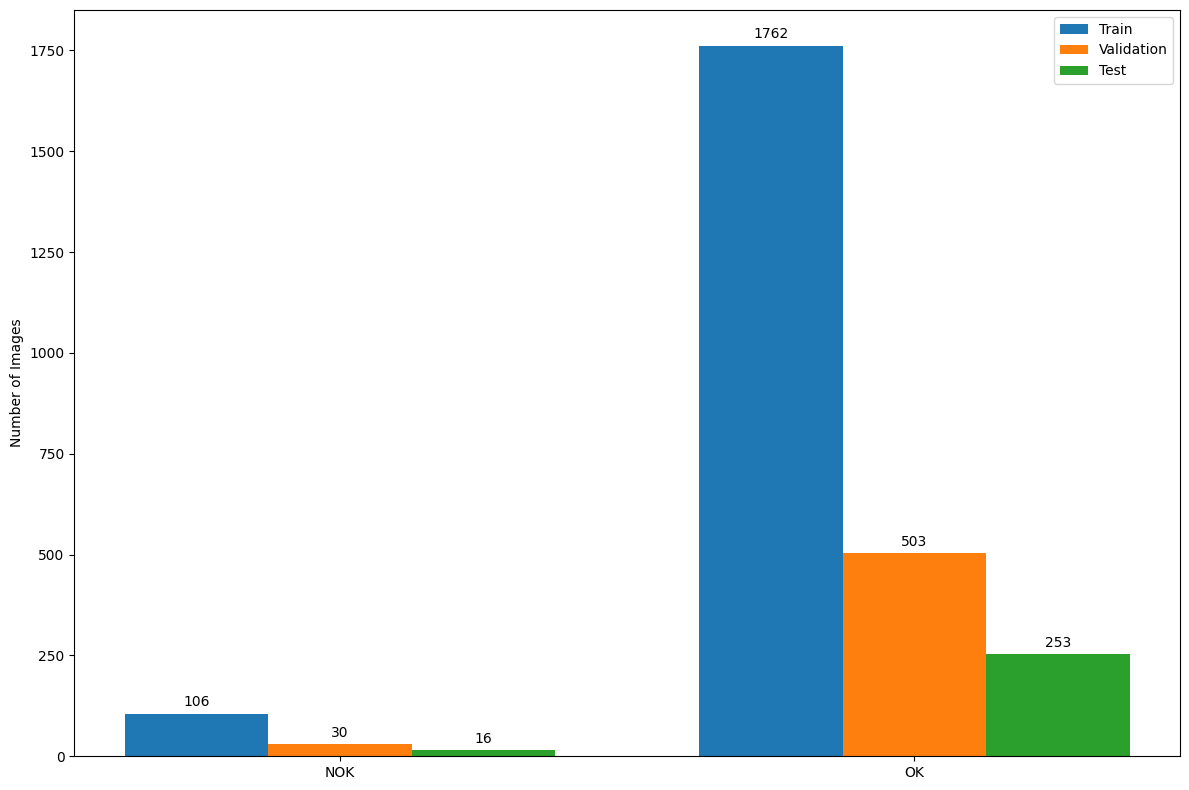

In [4]:
visualize_data(train_dir, val_dir, test_dir)

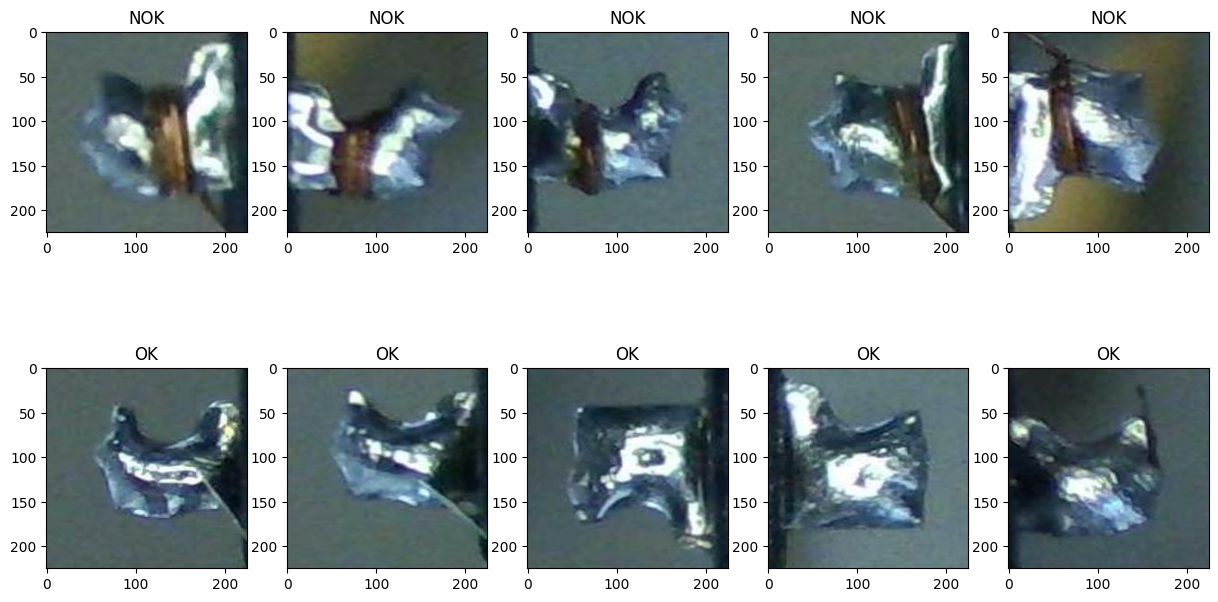

In [5]:
# Define the paths to the train directories for the "fail" and "pass" classes
fail_train_dir = os.path.join(data_dir, "train", "NOK")
pass_train_dir = os.path.join(data_dir, "train", "OK")

# Define the paths to a few images from each class
fail_images = [os.path.join(fail_train_dir, f) for f in os.listdir(fail_train_dir)[:5]]
pass_images = [os.path.join(pass_train_dir, f) for f in os.listdir(pass_train_dir)[:5]]

# Plot the images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 8))

for i, image_path in enumerate(fail_images):
    ax = axes[0, i]
    img = plt.imread(image_path)
    ax.imshow(img)
    #ax.axis('off')
    ax.set_title("NOK")

for i, image_path in enumerate(pass_images):
    ax = axes[1, i]
    img = plt.imread(image_path)
    ax.imshow(img)
    #ax.axis('off')
    ax.set_title("OK")

plt.show()

In [3]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
    rotation_range=20,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2 
    )

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    classes=["NOK", "OK"],
    seed=42,
    shuffle=True
    )

Found 1868 images belonging to 2 classes.


In [4]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    classes=["NOK", "OK"],
    seed=42,
    shuffle=True
    )

Found 533 images belonging to 2 classes.


In [5]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    classes=["NOK", "OK"],
    shuffle = False,
    seed=42
    )

Found 269 images belonging to 2 classes.


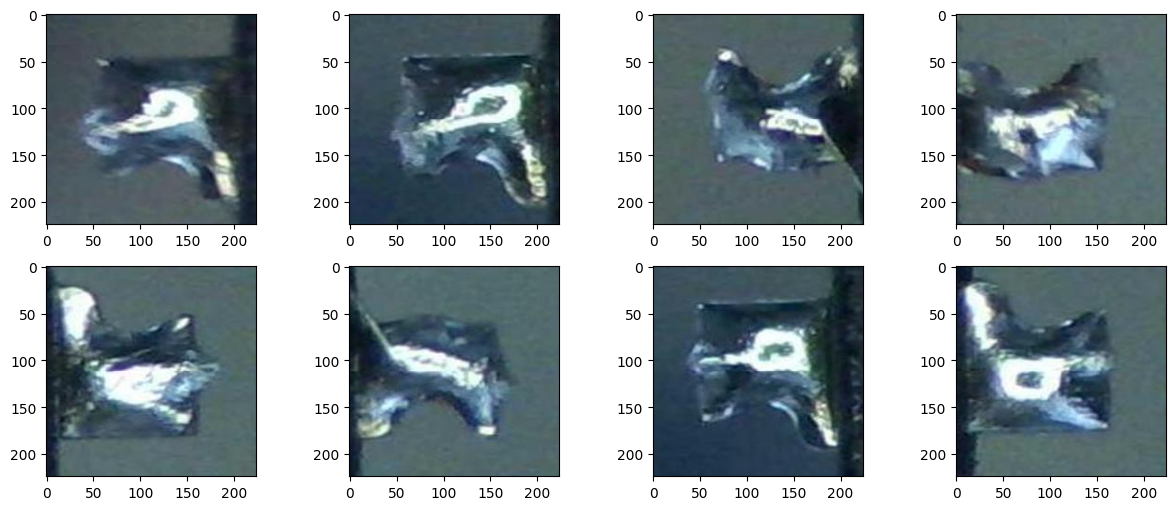

In [9]:
# Get a batch of images from the generator
img_batch, _ = train_data.next()

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(img_batch[i])
    ax.axis('on')
    
plt.show()

In [10]:
class_names = train_data.class_indices
class_names

{'NOK': 0, 'OK': 1}

In [11]:
# Get the class labels from the data generator
labels = train_data.classes

# Calculate the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_data.classes), y=labels)

# Convert the class weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))

In [12]:
class_weight_dict

{0: 8.81132075471698, 1: 0.5300794551645857}

In [13]:
base_model = DenseNet121(
        weights='imagenet', # Load pre-trained weights from the ImageNet dataset
        include_top=False, # Set to False to exclude the top fully connected layers from the model
        input_shape=(img_width, img_height, 3) # The input shape of the images
    )

gmp = GlobalAveragePooling2D()(base_model.output)

output = Dense(1, activation='sigmoid')(gmp)

model = Model(base_model.input, outputs=output)

In [14]:
for layer in base_model.layers:
    layer.trainable = False

In [15]:
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])    

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7fc2d4635eb0>,input_1,False
1,<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7fc234977820>,zero_padding2d,False
2,<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc234a18040>,conv1/conv,False
3,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fc2348e7580>,conv1/bn,False
4,<keras.layers.core.activation.Activation object at 0x7fc2348e7e50>,conv1/relu,False
...,...,...,...
424,<keras.layers.merging.concatenate.Concatenate object at 0x7fc234385670>,conv5_block16_concat,False
425,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fc234392550>,bn,False
426,<keras.layers.core.activation.Activation object at 0x7fc23437beb0>,relu,False
427,<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fc234b00100>,global_average_pooling2d,True


In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 28, 28, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 14, 14, 1024  4096        ['conv4_block24_concat[0][0]']   
                                )                                                                 
                                                                                                  
 pool4_relu (Activation)        (None, 14, 14, 1024  0           ['pool4_bn[0][0]']               
          

                                                                                                  
 conv5_block4_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block4_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 7, 7, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 7, 7, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization) 

 te)                                                              'conv5_block8_2_conv[0][0]']    
                                                                                                  
 conv5_block9_0_bn (BatchNormal  (None, 7, 7, 768)   3072        ['conv5_block8_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 7, 7, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 7, 7, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block13_1_conv (Conv2D)  (None, 7, 7, 128)    114688      ['conv5_block13_0_relu[0][0]']   
                                                                                                  
 conv5_block13_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block13_1_relu[0][0]']   
          

__________________________________________________________________________________________________


In [17]:
recall = Recall()
precision = Precision()

In [18]:
optimizer = SGD(learning_rate=0.01, decay=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy', recall, precision])

In [19]:
early_stopping_cb = EarlyStopping(patience=3,
                                  restore_best_weights=True,
                                  monitor='val_loss',
                                  mode='min')

In [20]:
EPOCHS = 10

num_workers = multiprocessing.cpu_count()
#workers=num_workers,
#use_multiprocessing=True,
#class_weight=class_weight_dict
history = model.fit(train_data, 
                      validation_data=val_data,
                      epochs=EPOCHS,
                      steps_per_epoch=(train_data.n//batch_size),
                      validation_steps=(val_data.n//batch_size),
                      callbacks=[early_stopping_cb],
                      class_weight=class_weight_dict
                  )

Epoch 1/10


2023-04-20 02:36:20.366165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


58/58 [==============================] - ETA: 0s - loss: 0.5152 - accuracy: 0.7516 - recall: 0.7514 - precision: 0.9804

2023-04-20 02:38:01.582649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


58/58 [==============================] - 131s 2s/step - loss: 0.5152 - accuracy: 0.7516 - recall: 0.7514 - precision: 0.9804 - val_loss: 0.1044 - val_accuracy: 0.9629 - val_recall: 0.9772 - val_precision: 0.9833
Epoch 2/10
58/58 [==============================] - 121s 2s/step - loss: 0.1677 - accuracy: 0.9466 - recall: 0.9463 - precision: 0.9970 - val_loss: 0.2858 - val_accuracy: 0.8848 - val_recall: 0.8822 - val_precision: 0.9953
Epoch 3/10
58/58 [==============================] - 121s 2s/step - loss: 0.1280 - accuracy: 0.9526 - recall: 0.9520 - precision: 0.9976 - val_loss: 0.0873 - val_accuracy: 0.9688 - val_recall: 0.9834 - val_precision: 0.9834
Epoch 4/10
58/58 [==============================] - 119s 2s/step - loss: 0.1055 - accuracy: 0.9635 - recall: 0.9642 - precision: 0.9970 - val_loss: 0.0957 - val_accuracy: 0.9629 - val_recall: 0.9751 - val_precision: 0.9853
Epoch 5/10
58/58 [==============================] - 121s 2s/step - loss: 0.0911 - accuracy: 0.9706 - recall: 0.9700 - p

In [21]:
len(base_model.layers)

427

In [22]:
for layer in base_model.layers:
  layer.trainable = True

In [ ]:
base_model.trainable = True
# Freeze the first 100 layers 
for layer in base_model.layers[:600]:
  layer.trainable = False

In [23]:
optimizer = SGD(learning_rate=0.001, decay=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy', recall, precision])

In [24]:
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
df = pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 
df 

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7fc2d4635eb0>,input_1,True
1,<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7fc234977820>,zero_padding2d,True
2,<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc234a18040>,conv1/conv,True
3,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fc2348e7580>,conv1/bn,True
4,<keras.layers.core.activation.Activation object at 0x7fc2348e7e50>,conv1/relu,True
...,...,...,...
424,<keras.layers.merging.concatenate.Concatenate object at 0x7fc234385670>,conv5_block16_concat,True
425,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fc234392550>,bn,True
426,<keras.layers.core.activation.Activation object at 0x7fc23437beb0>,relu,True
427,<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fc234b00100>,global_average_pooling2d,True


In [25]:
df['Layer Trainable'].value_counts()[True]

429

In [26]:
early_stopping_cb = EarlyStopping(patience=10,
                                  restore_best_weights=True,
                                  monitor='val_loss',
                                  mode='min')

In [27]:
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [28]:
checkpoint_cb = ModelCheckpoint('model_1.h5',
                                save_best_only=True,
                                monitor='val_loss',
                                mode='min')

In [29]:
csv_logger = CSVLogger('training_log.csv')

In [30]:
EPOCHS = 100

num_workers = multiprocessing.cpu_count()

history = model.fit(train_data, 
                      validation_data=val_data,
                      epochs=EPOCHS,
                      steps_per_epoch=(train_data.n//batch_size),
                      validation_steps=(val_data.n//batch_size),
                      callbacks=[early_stopping_cb,checkpoint_cb, reduce_lr_cb, csv_logger],
                      class_weight=class_weight_dict
                   )

Epoch 1/100


2023-04-20 02:48:35.243969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


58/58 [==============================] - ETA: 0s - loss: 0.2326 - accuracy: 0.8954 - recall: 0.9088 - precision: 0.9936

2023-04-20 02:56:41.011486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


58/58 [==============================] - 510s 9s/step - loss: 0.2326 - accuracy: 0.8954 - recall: 0.9088 - precision: 0.9936 - val_loss: 0.2663 - val_accuracy: 0.8965 - val_recall: 0.8967 - val_precision: 0.9931 - lr: 0.0010
Epoch 2/100
58/58 [==============================] - 500s 9s/step - loss: 0.0490 - accuracy: 0.9771 - recall: 0.9763 - precision: 0.9994 - val_loss: 0.0879 - val_accuracy: 0.9785 - val_recall: 0.9897 - val_precision: 0.9876 - lr: 0.0010
Epoch 3/100
58/58 [==============================] - 492s 8s/step - loss: 0.0180 - accuracy: 0.9973 - recall: 0.9977 - precision: 0.9994 - val_loss: 0.0703 - val_accuracy: 0.9863 - val_recall: 0.9979 - val_precision: 0.9878 - lr: 0.0010
Epoch 4/100
58/58 [==============================] - 488s 8s/step - loss: 0.0100 - accuracy: 0.9973 - recall: 0.9971 - precision: 1.0000 - val_loss: 0.0850 - val_accuracy: 0.9785 - val_recall: 0.9979 - val_precision: 0.9797 - lr: 0.0010
Epoch 5/100
58/58 [==============================] - 489s 8s/ste

In [31]:
def visualize_training_results(results):
    history = results.history
    
    # Find the epoch where validation accuracy was highest
    best_epoch = np.argmin(history['val_loss'])
    
    for m in ['loss', 'accuracy', 'precision', 'recall']:
        plt.figure(figsize=(15,5))
        plt.plot(history[m], label='Training', marker='o', color='blue')
        plt.plot(history[f'val_{m}'], label='Validation', marker='o', color='red')
        plt.axvline(x=best_epoch, linestyle='--', color='green', label='Best epoch')
        plt.xlabel('Epochs')
        plt.ylabel(m.title())
        plt.ylim()
        plt.legend()
        plt.title(m.title())
    
    plt.show()

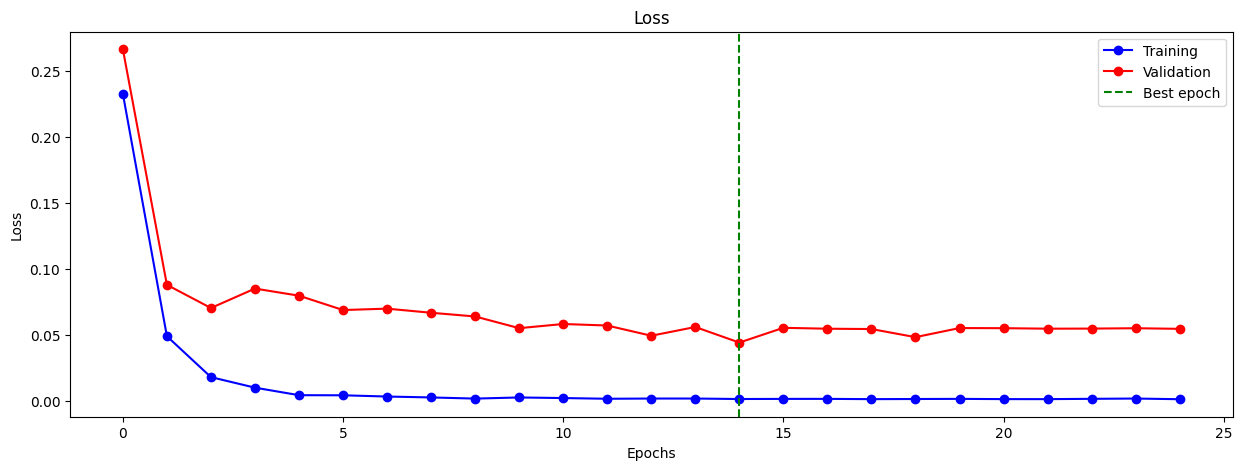

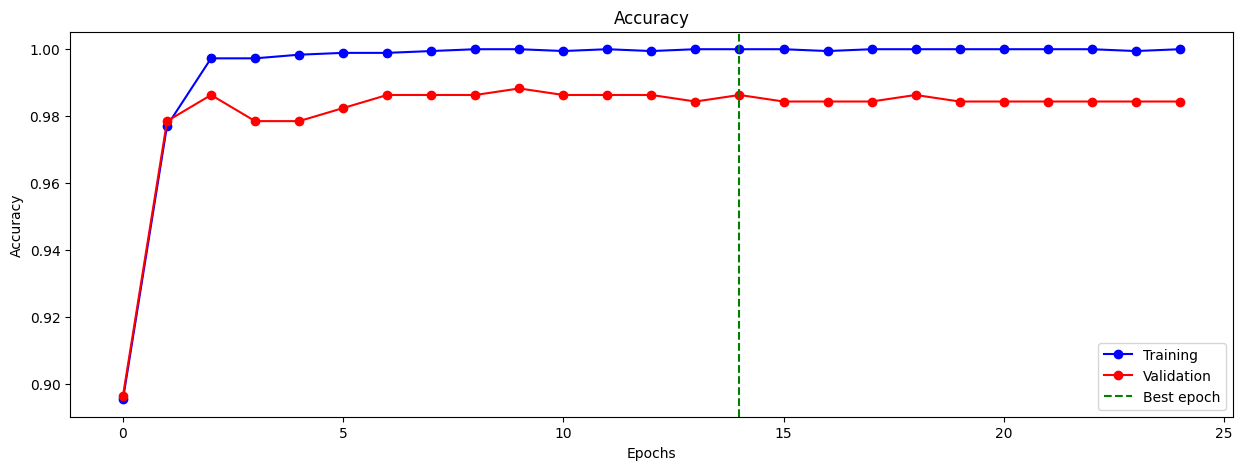

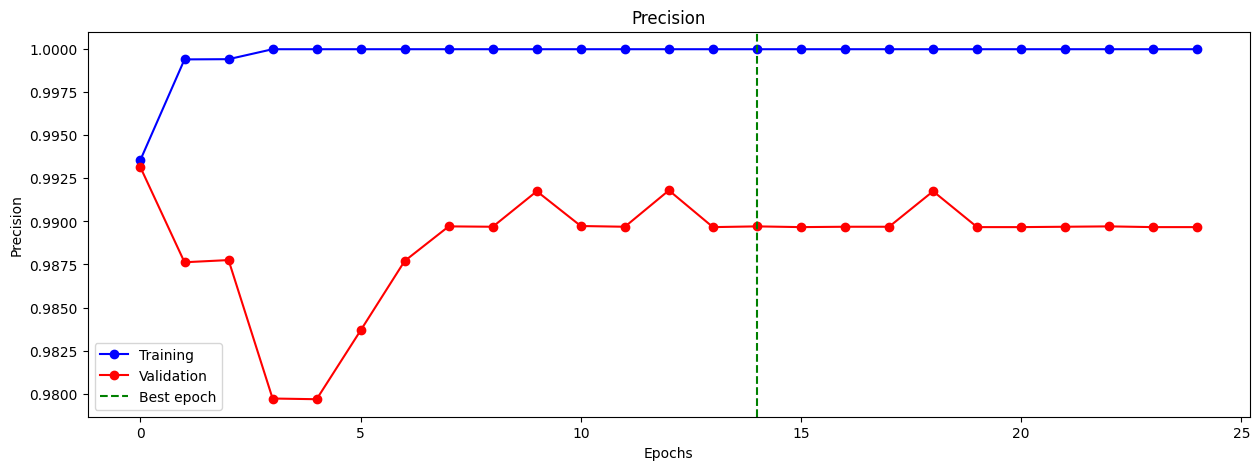

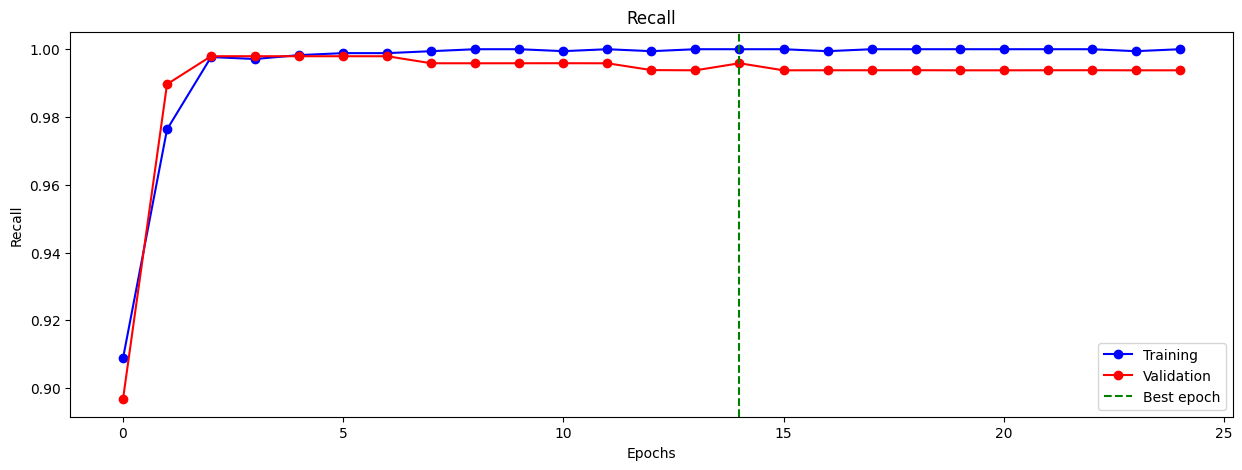

In [32]:
visualize_training_results(history)

In [6]:
def plot_metrics(model, test_data):
    # Get the predicted labels and true labels
    y_pred = model.predict(test_data)
    y_pred = y_pred > 0.5
    y_true = test_data.labels

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=ax1)
    ax1.set_xlabel('Predicted labels')
    ax1.set_ylabel('True labels')
    ax1.set_title('Confusion Matrix')
    ax1.xaxis.set_ticklabels(['NO OK', 'OK'])
    ax1.yaxis.set_ticklabels(['NO OK', 'OK'])

    # Calculate the true positive rate (TPR) and false positive rate (FPR) at different thresholds
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    # Calculate the area under the ROC curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    ax2.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    ax2.plot([0, 1], [0, 1], linestyle='--', label='Random guessing')

    ax2.set_xlabel('False Positive Rate (FPR)')
    ax2.set_ylabel('True Positive Rate (TPR)')
    ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax2.legend(loc="lower right")

    plt.show()
    
    # Generate the classification report
    report = classification_report(y_true, y_pred)
    # Print the report
    print(report)


2023-04-20 06:49:52.597216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


9/9 [==============================] - 14s 1s/step


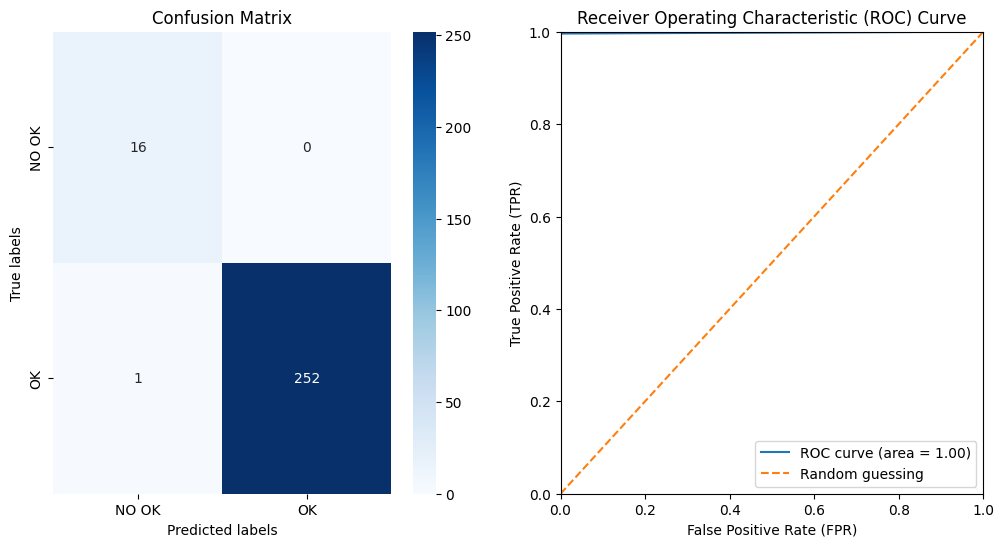

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       1.00      1.00      1.00       253

    accuracy                           1.00       269
   macro avg       0.97      1.00      0.98       269
weighted avg       1.00      1.00      1.00       269



In [34]:
plot_metrics(model, test_data)

In [35]:
# Print the metrics of the best epoch
best_epoch = np.argmin(history.history['val_loss'])
print("Best epoch: ", best_epoch)
print("Best loss: ", history.history['loss'][best_epoch])
print("Best accuracy: ", history.history['accuracy'][best_epoch])
print("Best recall: ", history.history['recall'][best_epoch])
print("Best precision: ", history.history['precision'][best_epoch])
print("Best val_loss: ", history.history['val_loss'][best_epoch])
print("Best val_accuracy: ", history.history['val_accuracy'][best_epoch])
print("Best val_recall: ", history.history['val_recall'][best_epoch])
print("Best val_precision: ", history.history['val_precision'][best_epoch])

Best epoch:  14
Best loss:  0.0014176646945998073
Best accuracy:  1.0
Best recall:  1.0
Best precision:  1.0
Best val_loss:  0.04415995255112648
Best val_accuracy:  0.986328125
Best val_recall:  0.9958592057228088
Best val_precision:  0.9897119402885437


In [7]:
from keras.models import load_model
saved_model = load_model('model_1.h5')

In [8]:
saved_model

2023-05-05 14:39:50.909323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


9/9 [==============================] - 14s 1s/step


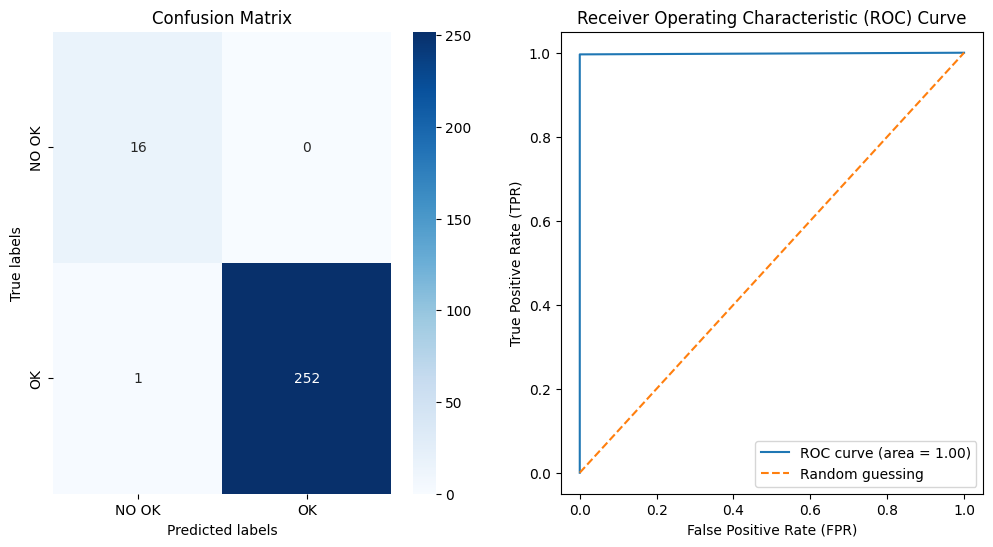

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       1.00      1.00      1.00       253

    accuracy                           1.00       269
   macro avg       0.97      1.00      0.98       269
weighted avg       1.00      1.00      1.00       269



In [9]:
plot_metrics(saved_model,test_data)